# Simulation Playground Notebook
This notebook is designed as a easy einterface to call the functions that we have defined

In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data, preprocess_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation
Let's prepare some data first to fit our model. We are specifically using ["Locus coeruleus activity strengthens prioritized memories under arousal"](https://openneuro.org/datasets/ds002011/versions/1.0.0) dataset fror now.

In [20]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

Let's preprocess our data first

In [21]:
X, Y, X_tensor, Y_tensor, scaler_X, scaler_Y, df_clean = preprocess_data(df_behavior)

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Training

In [23]:
from train import (train_feed_forward_nn,
                   train_vanilla_rnn,
                   train_vanilla_lstm,
                   train_vanilla_lc_model,
                   train_lstm_lc_model,
                   train_ff_controller
                   )
from analysis.evaluation import evaluate_model

## Fully Connected Neural Network

To illustrate our idea, we want to train 2 models from math and computer science, which is our vanilla feed forward networks and an recurrent networks.

Epoch 0, Loss: 0.07038737088441849
Epoch 100, Loss: 0.045955389738082886
Epoch 200, Loss: 0.0438985750079155
Epoch 300, Loss: 0.043523795902729034
Epoch 400, Loss: 0.04165048524737358
Epoch 500, Loss: 0.040909282863140106
Epoch 600, Loss: 0.042943138629198074
Epoch 700, Loss: 0.04000156745314598
Epoch 800, Loss: 0.0401424802839756
Epoch 900, Loss: 0.039426933974027634
Epoch 1000, Loss: 0.03811681270599365
Epoch 1100, Loss: 0.037516169250011444
Epoch 1200, Loss: 0.03791523724794388
Epoch 1300, Loss: 0.036765240132808685
Epoch 1400, Loss: 0.03669416531920433
Epoch 1500, Loss: 0.036317430436611176
Epoch 1600, Loss: 0.03624628484249115
Epoch 1700, Loss: 0.03755320608615875
Epoch 1800, Loss: 0.03601556643843651
Epoch 1900, Loss: 0.035630568861961365
Training complete!
Evaluating Model: FeedForwardNN


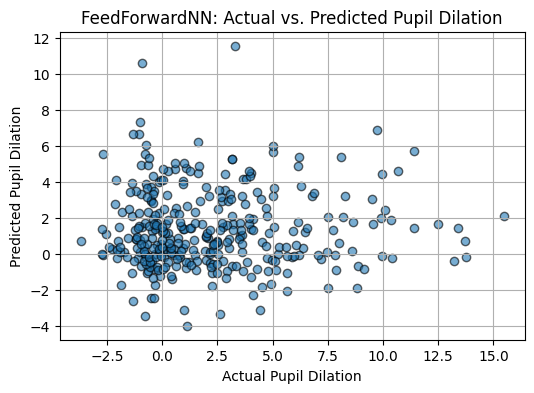

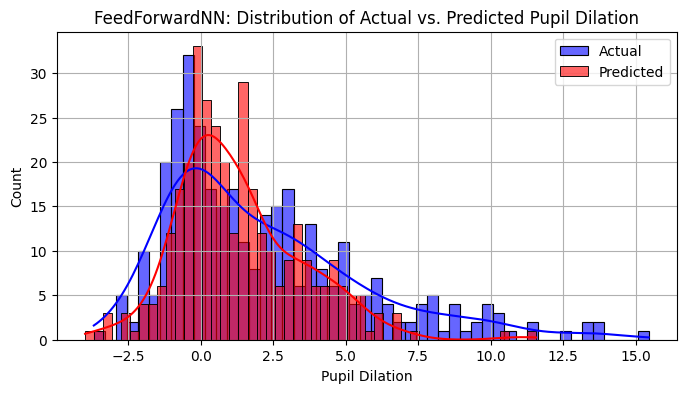

FeedForwardNN - Pearson Correlation: 0.0243


In [24]:
model_ff = train_feed_forward_nn(X_train, Y_train,epochs=2000)
evaluate_model(model_ff, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## Recurent Neural Networks

We will  do the same thing with an recurrent neural network

In [25]:
# model_rnn = train_vanilla_rnn(X_train, Y_train, epochs=2000)
# evaluate_model(model_rnn, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LSTM Models

In [26]:
# model_lstm = train_vanilla_lstm(X_train, Y_train, epochs=5000, hidden_dim=12)
# evaluate_model(model_lstm, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LCNECortex Fitter Model

Now coming to our customized LCNECortex model

Epoch 0, Loss: 1.452840805053711


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100, Loss: 0.9273170232772827
Epoch 200, Loss: 0.8901759386062622
Epoch 300, Loss: 0.9073094129562378
Epoch 400, Loss: 0.8891197443008423
Epoch 500, Loss: 0.8397171497344971
Epoch 600, Loss: 0.7833716869354248
Epoch 700, Loss: 0.9240055680274963
Epoch 800, Loss: 0.9346722364425659
Epoch 900, Loss: 0.8164358139038086
Epoch 1000, Loss: 0.8054590225219727
Epoch 1100, Loss: 0.8481827974319458
Epoch 1200, Loss: 0.8474327921867371
Epoch 1300, Loss: 0.8722217679023743
Epoch 1400, Loss: 0.8521554470062256
Epoch 1500, Loss: 0.8617881536483765
Epoch 1600, Loss: 0.7844895124435425
Epoch 1700, Loss: 0.8563064932823181
Epoch 1800, Loss: 0.8691323399543762
Epoch 1900, Loss: 0.8775812983512878
Training complete!
Evaluating Model: LCNECortexFitter


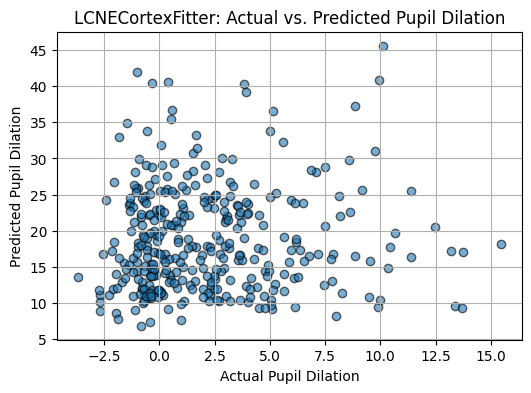

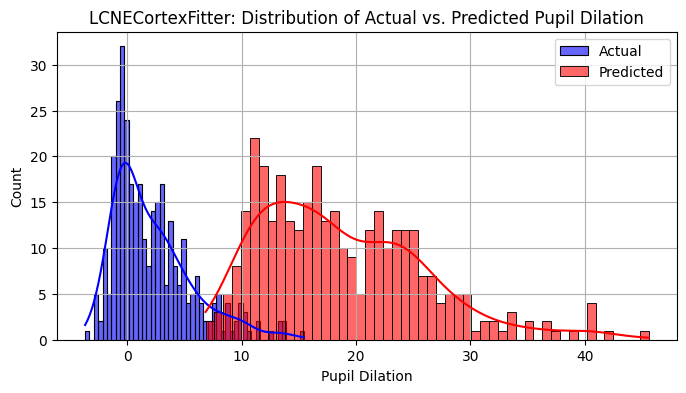

LCNECortexFitter - Pearson Correlation: 0.0541


In [27]:
model_lc_vanilla = train_vanilla_lc_model(X_train, Y_train, epochs=2000)
evaluate_model(model_lc_vanilla, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

## LSTM LCNECortex Model

In [28]:
# model_lc_lstm = train_lstm_lc_model(X_train, Y_train, epochs=2000, hidden_dim=64)
# evaluate_model(model_lc_lstm, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

# FF Gadget Model

Epoch 0, Loss: 0.045695


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 100, Loss: 0.022782
Epoch 200, Loss: 0.014958
Epoch 300, Loss: 0.028557
Epoch 400, Loss: 0.012064
Epoch 500, Loss: 0.016053
Epoch 600, Loss: 0.027548
Epoch 700, Loss: 0.019057
Epoch 800, Loss: 0.026290
Epoch 900, Loss: 0.020013
Epoch 1000, Loss: 0.038122
Epoch 1100, Loss: 0.030503
Epoch 1200, Loss: 0.023828
Epoch 1300, Loss: 0.011630
Epoch 1400, Loss: 0.015582
Epoch 1500, Loss: 0.024634
Epoch 1600, Loss: 0.018762
Epoch 1700, Loss: 0.040725
Epoch 1800, Loss: 0.025870
Epoch 1900, Loss: 0.034213
Epoch 2000, Loss: 0.020633
Epoch 2100, Loss: 0.032133
Epoch 2200, Loss: 0.013450
Epoch 2300, Loss: 0.021445
Epoch 2400, Loss: 0.055152
Epoch 2500, Loss: 0.022052
Epoch 2600, Loss: 0.024433
Epoch 2700, Loss: 0.028199
Epoch 2800, Loss: 0.038870
Epoch 2900, Loss: 0.022179
Epoch 3000, Loss: 0.020878
Epoch 3100, Loss: 0.028560
Epoch 3200, Loss: 0.018646
Epoch 3300, Loss: 0.024877
Epoch 3400, Loss: 0.017478
Epoch 3500, Loss: 0.027004
Epoch 3600, Loss: 0.013250
Epoch 3700, Loss: 0.028939
Epoch 3800

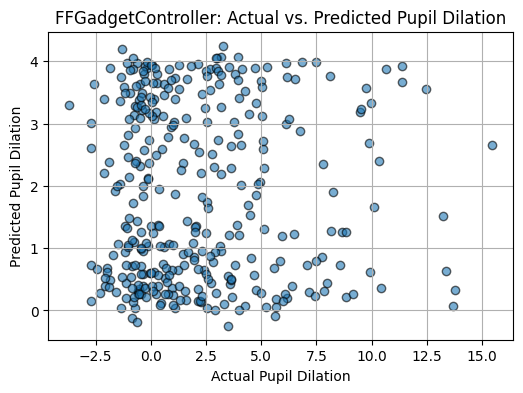

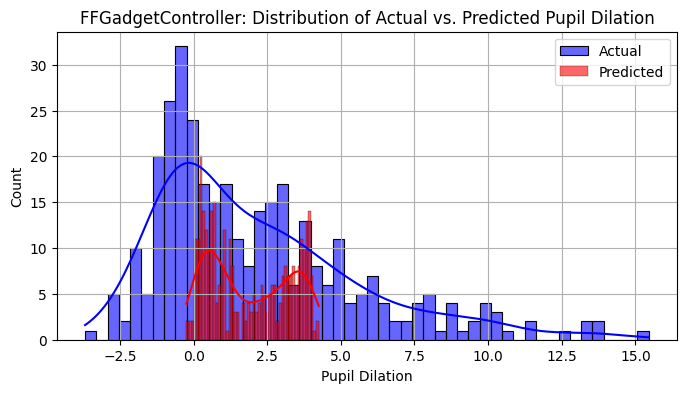

FFGadgetController - Pearson Correlation: 0.0040


In [29]:
ff_gadget = train_ff_controller(X_train, Y_train, epochs=5000, hidden_dim=264)
evaluate_model(ff_gadget, X_test, Y_test, df_clean, scaler_Y=scaler_Y)

Interesting results

# Analysis

In [30]:
from analysis.analysis import (pca_lcne_lstm,
                               pca_feed_forward,
                               pca_lcne,
                               pca_lstm,
                               analyze_ff_gadget_activations,
)

## Feed-Forward Neural Networks

In [31]:
# pca_feed_forward(model_ff, X_tensor, df_behavior)

## LCNECortex Model

We will see that, though  under fitted with the real data, there are some structureness to the data that we can play around with since we injected mechanistic insights into it.

Text(0.5, 1.0, 'Cortex Activation Distribution')

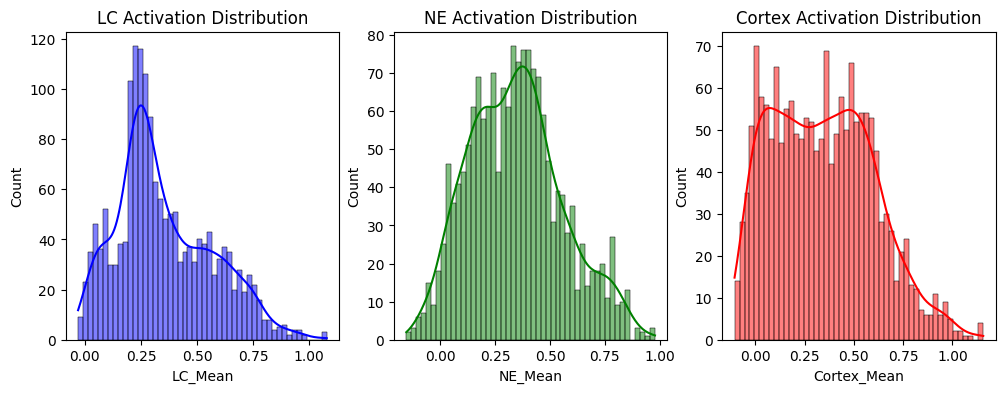

In [32]:
with torch.no_grad():
    prev_LC = torch.zeros(X_tensor.shape[0], model_lc_vanilla.hidden_dim)
    prev_Cortex = torch.zeros(X_tensor.shape[0], model_lc_vanilla.hidden_dim)

    LC_act, NE_act, C_act, Pupil_pred, LC_raw, NE_raw, C_raw = model_lc_vanilla(X_tensor, prev_LC, prev_Cortex, return_activations=True)

act_lc = LC_act.cpu().numpy()
act_ne = NE_act.cpu().numpy()
act_cortex = C_act.cpu().numpy()

df_activations = pd.DataFrame({
    'LC_Mean': act_lc.mean(axis=1),
    'NE_Mean': act_ne.mean(axis=1),
    'Cortex_Mean': act_cortex.mean(axis=1),
    'PupilPred': Pupil_pred.cpu().numpy().squeeze(),
    'ActualPupil': df_clean['Event_PupilDilation'].values  # Ensure this aligns with X_tensor
})

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df_activations['LC_Mean'], kde=True, bins=50, color='blue')
plt.title("LC Activation Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df_activations['NE_Mean'], kde=True, bins=50, color='green')
plt.title("NE Activation Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df_activations['Cortex_Mean'], kde=True, bins=50, color='red')
plt.title("Cortex Activation Distribution")

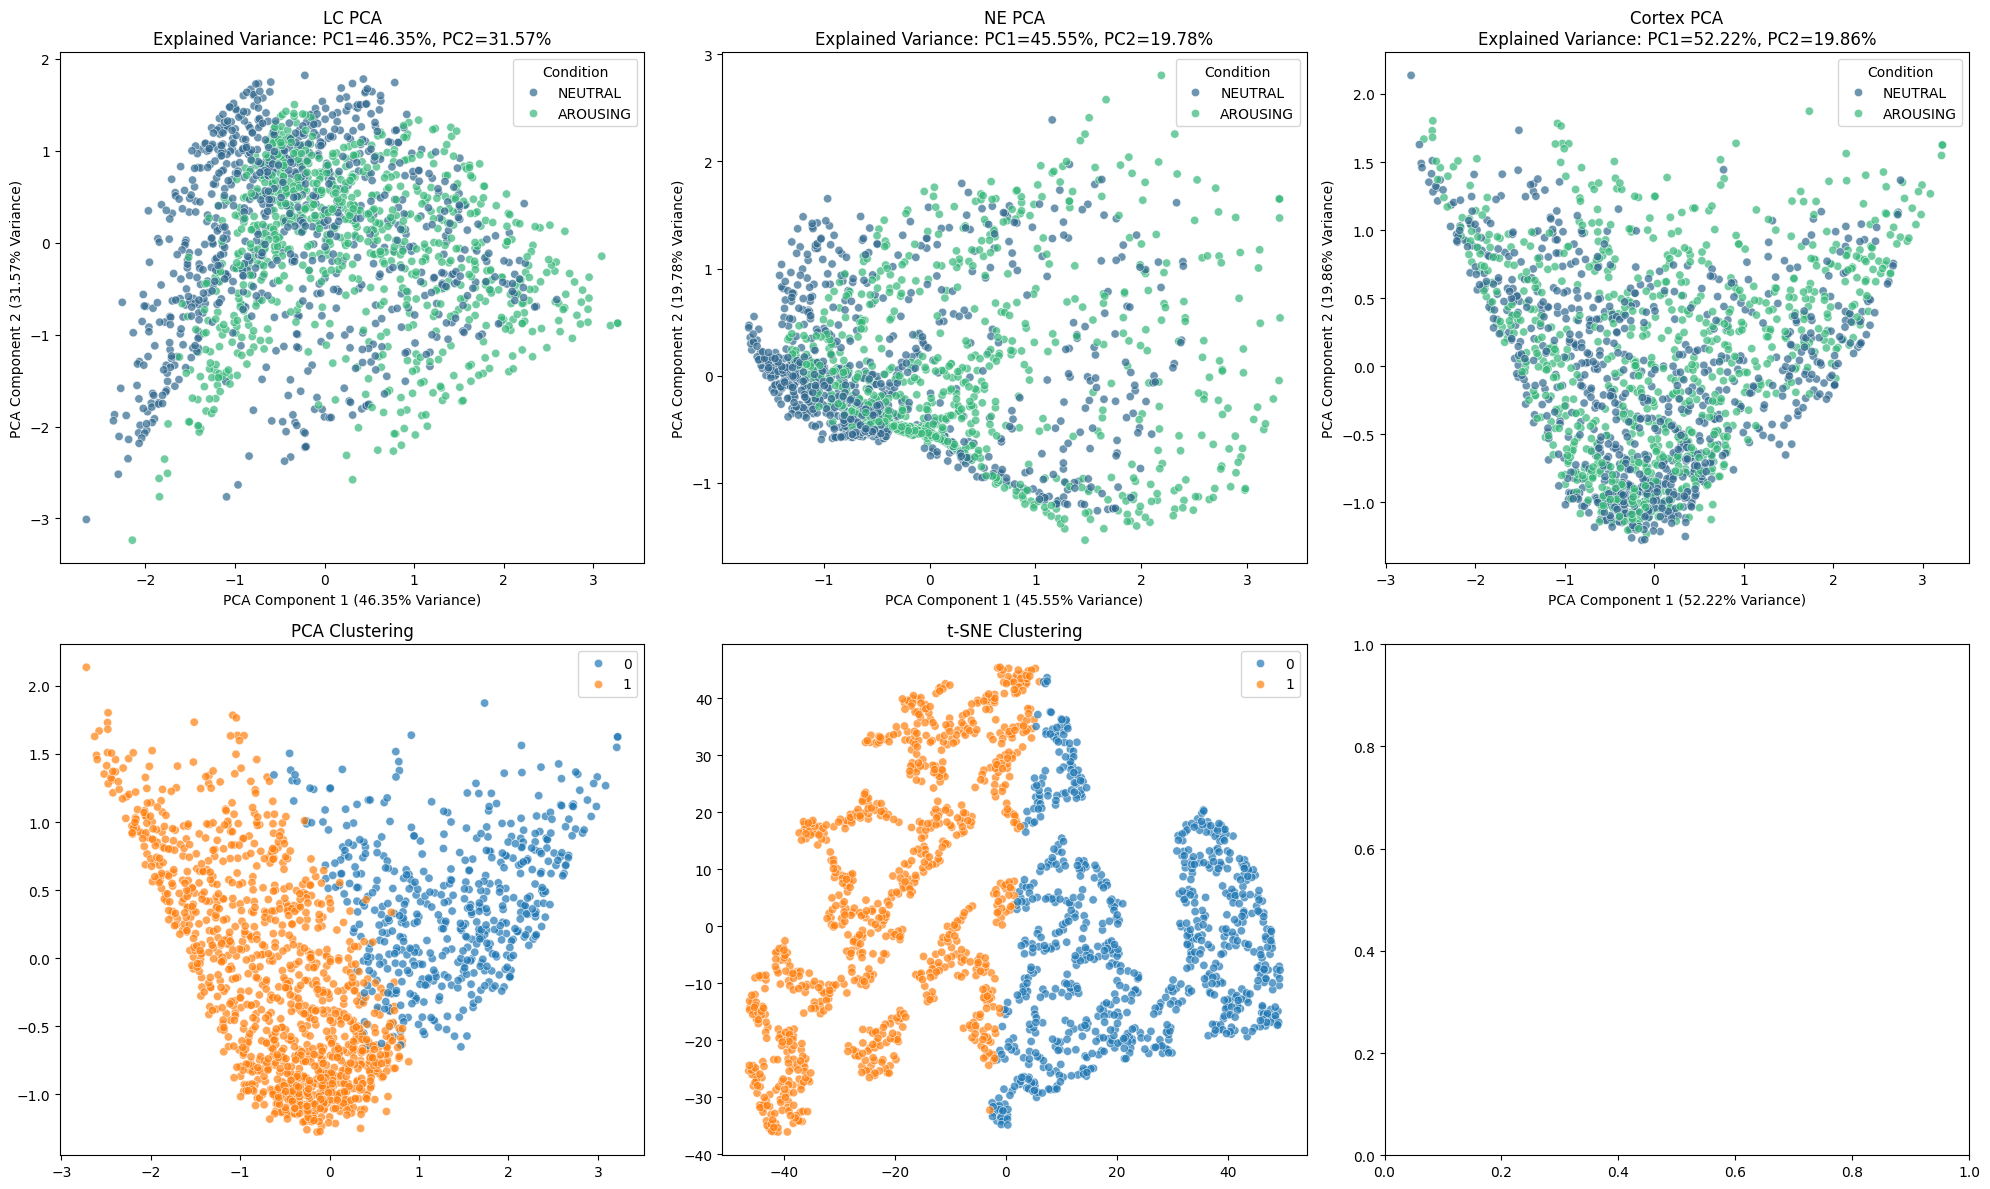

In [33]:
pca_lcne(model_lc_vanilla, X_tensor, df_clean)

## LSTM LCNECortex Model

In [34]:
# pca_lcne_lstm(model_lc_lstm, X_tensor, df_clean)

## Vanilla LSTM Comparison

In [35]:
# pca_lstm(model_lstm, X_test, df_clean)

## FF Gadget Model

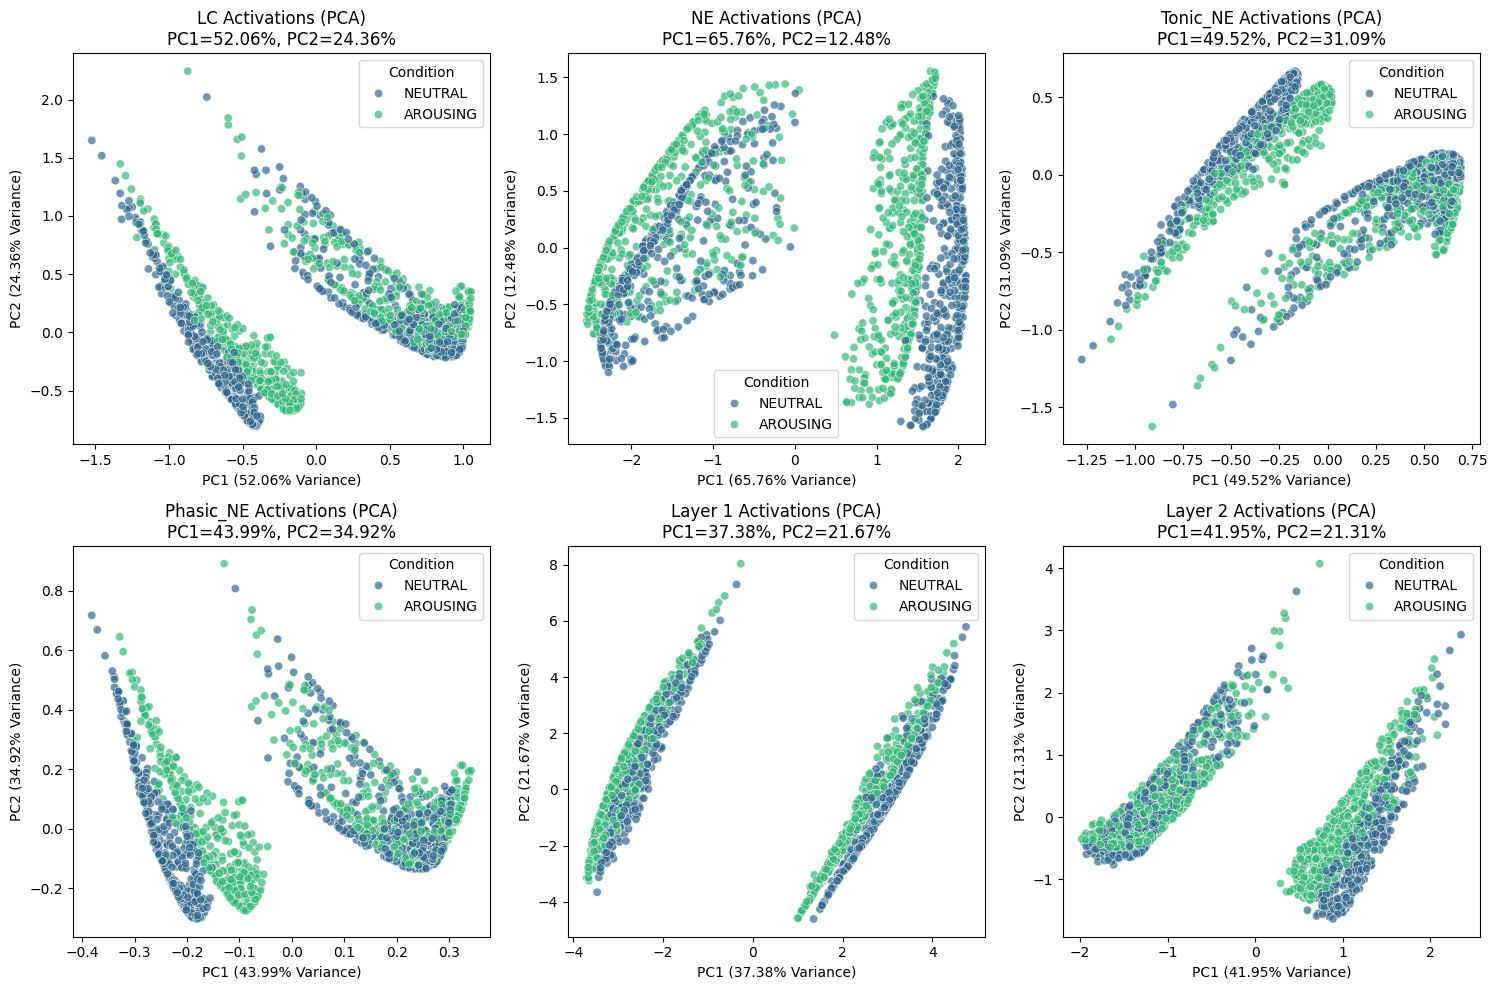

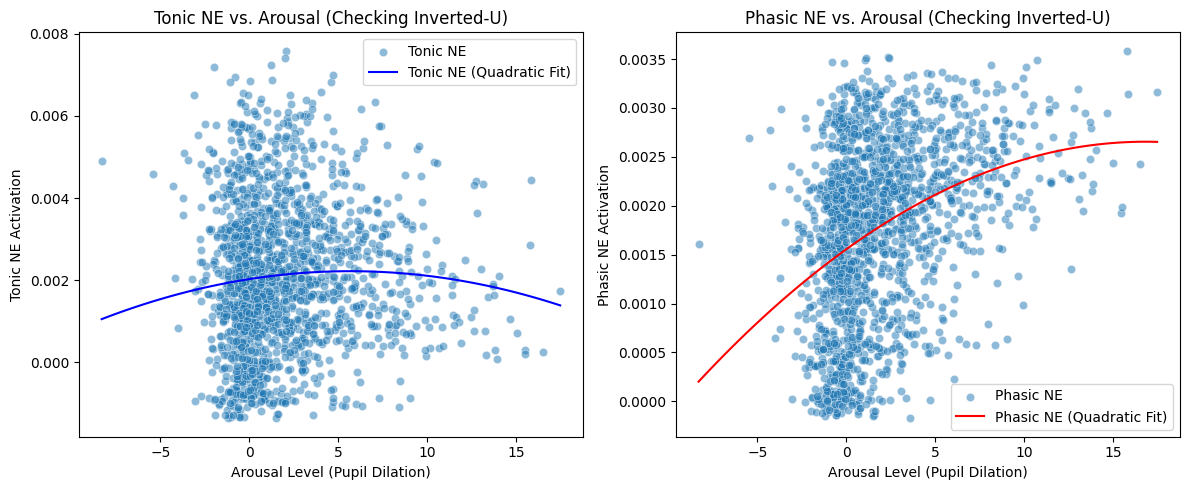


 Pearson Correlation with Actual Pupil Dilation:
LC: 0.417
NE: -0.277
Tonic_NE: 0.032
Phasic_NE: 0.359
Layer 1: -0.163
Layer 2: -0.169
Predicted Pupil Dilation: 0.445


In [36]:
analyze_ff_gadget_activations(ff_gadget, X_tensor, df_clean)

This model elarning representation is quite unstable